In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt

import spatialpower.neighborhoods.permutationtest as perm_test


## Load data and filter to one tile

In [2]:
#Load data

df = pd.read_csv('/Users/ethan/Dropbox (MIT)/Lab/datasets/CODEX_Spleen/CODEX_MRLdataset_neighborhood_graph.csv', header = 0)
balbc1 = df[df['Cell1 Sample_Xtile_Ytile'].str.startswith('BALBc-1')]
tile_names = np.sort(balbc1['Cell1 Sample_Xtile_Ytile'].unique())

### Stitch

In [3]:
x_boundary = 0
x_adjustments = dict()
y_boundary = 0
y_adjustments = dict()

for x in range(1, 7):
    
    if x == 1:
        x_adjustments[x] = 0
   
    key = 'BALBc-1_X0' + str(x) + '_Y01'
    max_x = max(balbc1[balbc1['Cell1 Sample_Xtile_Ytile'] == key]['X1'])
    x_boundary += max_x
    x_adjustments[x + 1] = x_boundary

for y in range(1,9):
    
    if y == 1:
        y_adjustments[y] = 0
    
    key = 'BALBc-1_X01_Y0' + str(y)
    max_y = max(balbc1[balbc1['Cell1 Sample_Xtile_Ytile'] == key]['Y1'])
    y_boundary += max_y
    y_adjustments[y + 1] = y_boundary
    

df['X1_adjusted'] = np.NaN
df['Y1_adjusted'] = np.NaN

for tile in tile_names:
    df[df['Cell1 Sample_Xtile_Ytile'] == tile]

In [4]:
def adjust_x(key):
    #key = z['Cell1 Sample_Xtile_Ytile'].to_list()[0]
    x = int(key.split('_')[1].split('X')[1])
    #y = int(key.split('_')[2].split('Y')[1])
    adjustment = x_adjustments[x]
    return adjustment

def adjust_y(key):
    #key = z['Cell1 Sample_Xtile_Ytile'].to_list()[0]
    #x = int(key.split('_')[1].split('X')[1])
    y = int(key.split('_')[2].split('Y')[1])
    adjustment = y_adjustments[y]
    return adjustment

def make_identifier(df):
    str_id = df.apply(lambda x: '_'.join(map(str, x)), axis=1)
    return str_id


In [5]:
df['X1_adjusted'] = df['X1'] + df['Cell1 Sample_Xtile_Ytile'].apply(adjust_x)
df['Y1_adjusted'] = df['Y1'] + df['Cell1 Sample_Xtile_Ytile'].apply(adjust_y)

df['X2_adjusted'] = df['X2'] + df['Cell2 Sample_Xtile_Ytile'].apply(adjust_x)
df['Y2_adjusted'] = df['Y2'] + df['Cell2 Sample_Xtile_Ytile'].apply(adjust_y)

source = df['Cell1 Imaging phenotype cluster ID'].tolist()
sink = df['Cell2 Imaging phenotype cluster ID'].tolist()

source_x_positions = df['X1_adjusted'].tolist()
source_y_positions = df['Y1_adjusted'].tolist()
sink_x_positions = df['X2_adjusted'].tolist()
sink_y_positions = df['Y2_adjusted'].tolist()

df['source_cell_ID'] = make_identifier(df[['X1_adjusted','Y1_adjusted']])
df['sink_cell_ID'] = make_identifier(df[['X2_adjusted','Y2_adjusted']])

source_id = df['source_cell_ID'].tolist()
sink_id = df['sink_cell_ID'].tolist()
unique_ids = np.unique(source_id)
new_ID = [i for i in range(0, len(unique_ids))]
new_id_dict = dict(zip(unique_ids, new_ID))
df['source_id'] = df['source_cell_ID'].map(new_id_dict)
df['sink_id'] = df['sink_cell_ID'].map(new_id_dict)
df.tail()

,Cell1 Sample_Xtile_Ytile,X1,Y1,Cell1 Imaging phenotype cluster ID,Cell2 Sample_Xtile_Ytile,X2,Y2,Cell2 Imaging phenotype cluster ID,X1_adjusted,Y1_adjusted,X2_adjusted,Y2_adjusted,source_cell_ID,sink_cell_ID,source_id,sink_id
4310493,MRL-5_X04_Y09,550,471,9595,MRL-5_X04_Y09,509,464,9613,4569,8506,4528,8499,4569_8506,4528_8499,315254,311576
4310494,MRL-5_X04_Y09,232,614,9613,MRL-5_X04_Y09,201,600,9613,4251,8649,4220,8635,4251_8649,4220_8635,286065,283258
4310495,MRL-5_X04_Y09,236,624,9596,MRL-5_X04_Y09,247,639,9613,4255,8659,4266,8674,4255_8659,4266_8674,286393,287387
4310496,MRL-5_X04_Y09,973,980,9619,MRL-5_X04_Y09,1024,972,9619,4992,9015,5043,9007,4992_9015,5043_9007,354507,359312
4310497,MRL-5_X04_Y09,550,471,9595,MRL-5_X04_Y09,542,443,9613,4569,8506,4561,8478,4569_8506,4561_8478,315254,314592


### Add type info

In [8]:
clusters = pd.read_csv("/Users/ethan/Dropbox (MIT)/Lab/spatial-data-generation_brokengit/circle_packing/spleen_data/cluster_labels.csv", header = 0)

cluster_labels = clusters['Imaging phenotype (cell type)'].unique()
cluster_label_ID = [i for i in range(0,len(cluster_labels))]
cluster_dict = dict(zip(cluster_labels, cluster_label_ID))

clusters['cluster_id'] = clusters['Imaging phenotype (cell type)'].map(cluster_dict)

xshift = clusters['X-shift cluster ID'].tolist()
cluster_id = clusters['cluster_id'].tolist()
xshift_cluster_dict = dict(zip(xshift, cluster_id))

In [9]:
df2 = df.drop_duplicates(subset=['source_id'])
df2['cell_type'] = df2['Cell1 Imaging phenotype cluster ID'].map(xshift_cluster_dict)
cell_id_type_dict = dict(zip(df2['source_id'].tolist(), df2['cell_type'].tolist()))

/Users/ethan/miniconda3/envs/spleen/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
df2_nodirt = df2.drop(df2[df2['cell_type'] == 6].index)
df3 = df2_nodirt[df2_nodirt['Cell1 Sample_Xtile_Ytile'].isin(tile_names)]

## Build a graph

In [11]:
pos = []
for i in df3.index.tolist():
    x = df3.loc[i, 'X1_adjusted']
    y = df3.loc[i, 'Y1_adjusted']
    p = [x, y]
    pos.append(p)

position_dict = dict(zip(df3['source_id'].tolist(),pos))

In [12]:
edgelist = []
for i in df.index.tolist():
    source = df.loc[i, "source_id"]
    sink = df.loc[i, "sink_id"]
    edgelist.append((source, sink))

G = nx.from_edgelist(edgelist)
nx.set_node_attributes(G, cell_id_type_dict, 'cell_type')

In [13]:
new_types = []
typelist = np.array(df3['cell_type'])
for t in typelist:
    if t == 16:
        new_types.append(1)
    elif t == 14:
        new_types.append(2)
    else:
        new_types.append(0)

df3['newtype'] = new_types

/Users/ethan/miniconda3/envs/spleen/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## Spatial Analysis

In [14]:
import datetime
import scipy.sparse as sparse
import spatialpower.neighborhoods.permutationtest as perm_test
import multiprocessing as mp
from datetime import datetime
import errno
from joblib import Parallel, delayed
import os
from glob import glob

In [15]:
def build_assignment_matrix(attribute_dict, n_cell_types):
    data = list(attribute_dict.items())
    data = np.array(data)  # Assignment matrix

    B = np.zeros((data.shape[0], n_cell_types))  # Empty matrix

    for i in range(0, data.shape[0]):
        t = data[i, 1]
        B[i, int(t)] = 1

    return B

def run_test(results_path, A, B, H_gt, size, n_jobs, trials, plot, graph, graph_id, threshold):
    '''
    Runs the permutation test, and calculates signficant interaction pairs.

    Parameters
    ----------
        results_path: str, the root results dir
        size : int, size of graph to calculate.
        n_jobs: int, number of parallel jobs to spawn
        trials: int, number of shuffles in empirical distribution
        plot : bool, generate histogram of each pairwise relation if True.

    Returns
    -------
        None
    '''
    # Make results dir
    try:
        os.mkdir(results_path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass

    # Perform calculations.
    results = []
    if graph_id == None:
        out_dir = results_path + str(size) + '_cells/'
    else:
        out_dir = results_path + str(size) + '_cells_' + str(graph_id) + '/'

    try:
        os.mkdir(out_dir)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    
    n_cell_types = B.shape[1]
    args = (A, B, size, graph, n_cell_types)
    arg_list = [args for i in range(0, trials)]
    results = Parallel(n_jobs=n_jobs, verbose=1, backend="sequential")(
        delayed(perm_test.permutation_test_trial_wrapper)(args) for args in arg_list)
    #parse_results(results, size, out_dir)

    # Process results

    '''# size_list = []
    result_list = []

    file_list = glob(out_dir + '*.npy')
    for f in file_list:
        arr = np.load(f)
        # size_list.append(size)
        result_list.append(arr)'''

    arr = np.dstack(results)  # stack into a 3-D array
    n_types = arr.shape[0]

    enriched_pairs = []
    depleted_pairs = []

    for i in range(0, n_types):
        for j in range(0, n_types):
            ground_truth_score = H_gt[i, j]
            emp_dist = arr[i, j, :]
            indices, = np.where(emp_dist < ground_truth_score)
            p = (len(emp_dist) - len(indices) + 1) / (len(emp_dist) + 1)
            if p <= threshold:
                enriched_pairs.append([i, j, p])
            elif p >= 1 - threshold:
                depleted_pairs.append([i, j, p])

            # Visualize empirical distribution
            if plot == True:
                plt.clf()
                # sns.set(style = 'white')
                plt.hist(arr[2, 2, :], color='k')
                plt.xlim(0, 1)
                plt.xlabel("Probability of Interaction between " + str(i) + " and " + str(j))
                plt.ylabel("Count")
                plt.savefig(out_dir + "distplot_" + str(i) + "_" + str(j) + ".pdf")

    # Write results matrix.
    np.save(out_dir + "enriched_pairs.npy", np.array(enriched_pairs))
    np.save(out_dir + "depleted_pairs.npy", np.array(depleted_pairs))

    return

def run_test_nosave(A, B, H_gt, size, n_jobs, trials, graph, threshold, out_dir=None):
    '''
    Runs the permutation test, and calculates signficant interaction pairs.

    Parameters
    ----------
        size : int, size of graph to calculate.
        n_jobs: int, number of parallel jobs to spawn
        trials: int, number of shuffles in empirical distribution
        plot : bool, generate histogram of each pairwise relation if True.  

    Returns
    -------
        enriched_pairs  :   array-like
        depleted_pairs  :   array-like
    '''
   
    n_cell_types = B.shape[1]
    args = (A, B, size, graph, n_cell_types)
    arg_list = [args for i in range(0, trials)]
    results = Parallel(n_jobs=n_jobs, verbose=0, backend="sequential")(
        delayed(perm_test.permutation_test_trial_wrapper)(args) for args in arg_list)
    #parse_results(results, size, out_dir)

    arr = np.dstack(results)  # stack into a 3-D array
    n_types = arr.shape[0]

    enriched_pairs = []
    depleted_pairs = []

    for i in range(0, n_types):
        for j in range(0, n_types):
            ground_truth_score = H_gt[i, j]
            emp_dist = arr[i, j, :]
            indices, = np.where(emp_dist < ground_truth_score)
            p = (len(emp_dist) - len(indices) + 1) / (len(emp_dist) + 1)
            if p <= threshold:
                enriched_pairs.append([i, j, p])
            elif p >= 1 - threshold:
                depleted_pairs.append([i, j, p])

    # Write results matrix.
    #np.save(out_dir + "enriched_pairs.npy", np.array(enriched_pairs))
    #np.save(out_dir + "depleted_pairs.npy", np.array(depleted_pairs))

    return enriched_pairs, depleted_pairs

In [16]:
attribute_dict = dict(zip(df3['source_id'], df3['newtype']))
full_graph = G.subgraph(df3['source_id'])

In [17]:
A_full = nx.convert_matrix.to_scipy_sparse_matrix(full_graph)
B_full = build_assignment_matrix(attribute_dict, 3)
p = np.divide(np.sum(B, axis=0), A.shape[0])
H = perm_test.calculate_neighborhood_distribution_sparse(A, B)

NameError: name 'B' is not defined

## Disrupt CD4/CD8 Interaction by swapping CD4 cells to null type (e.g. moving in graph to preserve frequencies)

In [18]:
#type 14 --> type 16

from tqdm import trange


AB = A_full @ B_full
C = B_full.T @ AB

cd4_cells = list(df3[df3['newtype']==2].index)
n_cd4 = len(cd4_cells)
#n_to_change = int(np.floor(C[1,2]*frac_to_change))

cd4_cell_idx = []
df3idx = np.array(df3.index, dtype=int)

for i in trange(0, len(df3idx)):
    if df3idx[i] in cd4_cells:
        cd4_cell_idx.append(i)

cd4_cell_idx = np.array(cd4_cell_idx)

idx, = np.where(AB[cd4_cell_idx,1] > 0)
cd4_cells_with_cd8_nbr = cd4_cell_idx[idx] # these are the indexes for A/B/AB not the df 
# Now find generic-generic pairs to send them to
generic_cells = list(df3[df3['newtype']==0].index)
generic_cell_idx = []

for i in trange(0, len(df3idx)):
    if df3idx[i] in generic_cells:
        generic_cell_idx.append(i)

generic_cell_idx = np.array(generic_cell_idx)
idx, = np.where(AB[generic_cell_idx, 0] == 0)
generic_pairs = generic_cell_idx[idx] # these are the indexes for A/B/AB not the df 



100%|██████████| 81964/81964 [05:38<00:00, 241.79it/s]


In [36]:
frac_to_change = 1
n_to_change = int(np.floor(len(cd4_cells_with_cd8_nbr)*frac_to_change))
to_swap = np.random.choice(cd4_cell_idx, size = n_to_change, replace=False)

if len(generic_pairs) >= n_to_change:
    targets = np.random.choice(generic_pairs, size = n_to_change, replace=False)
else:
    targets = [i for i in generic_pairs]
    remainder = n_to_change - len(targets)

    while len(targets) < n_to_change:
        addtl_target = np.random.choice(generic_cell_idx)
        if addtl_target not in targets:
            targets.append(addtl_target)

targets = np.array(targets)
B_full_mod = B_full.copy()

B_full_mod[to_swap[:len(targets)], :] = np.array([1, 0, 0]) #CD4 -> Blank
B_full_mod[targets, :] = np.array([0, 0, 1]) # Blank -> CD4

#np.random.shuffle(B_full_mod)
df4 = df3.copy()
df4['newtype'] = np.argmax(B_full_mod, axis = 1)

In [37]:
AB = A_full @ B_full_mod
B_full_mod.T @ AB

array([[247970.,  55163.,  28084.],
       [ 55163.,  28764.,   8561.],
       [ 28084.,   8561.,   3248.]])

## Draw FOVs from the two samples and perform a permutation test

In [38]:
def calculate_FOV_size(sampling_frac, min_x, max_x, min_y, max_y):
    area = (max_x - min_x) * (max_y - min_y)
    sampling_area = sampling_frac * area
    FOV_dim = np.round(np.sqrt(sampling_area))
    return FOV_dim

def random_FOV(FOV_dim, df, min_x, max_x, min_y, max_y):
    x_start = np.random.randint(min_x, max_x - FOV_dim)
    y_start = np.random.randint(min_y, max_y - FOV_dim)
    
    x_filtered = df[(df['X1_adjusted'] > x_start) & (df['X1_adjusted'] < x_start + FOV_dim)]
    random_FOV = x_filtered[(x_filtered['Y1_adjusted'] > y_start) & (x_filtered['Y1_adjusted'] < y_start + FOV_dim)]
    
    return random_FOV
    
def random_FOV_plot(FOV_dim, df, min_x, max_x, min_y, max_y):
    x_start = np.random.randint(min_x, max_x - FOV_dim)
    y_start = np.random.randint(min_y, max_y - FOV_dim)
    
    x_filtered = df[(df['X1_adjusted'] > x_start) & (df['X1_adjusted'] < x_start + FOV_dim)]
    random_FOV = x_filtered[(x_filtered['Y1_adjusted'] > y_start) & (x_filtered['Y1_adjusted'] < y_start + FOV_dim)]
    
    x_coords = [x_start, x_start + FOV_dim]
    y_coords = [y_start, y_start + FOV_dim]
    return random_FOV, x_coords, y_coords

def detect_enrichments(fov, graph, out_dir=None):
    
    attribute_dict = dict(zip(fov['source_id'], fov['newtype']))
    full_graph2 = graph.subgraph(fov['source_id'])
    A = nx.convert_matrix.to_scipy_sparse_matrix(full_graph2)
    B = build_assignment_matrix(attribute_dict, 3) #IMPORTANT 
    p = np.divide(np.sum(B, axis=0), A.shape[0])
    H = perm_test.calculate_neighborhood_distribution_sparse(A, B)
    
    #out_dir = './spleen_data/for_paper/full'
    now = datetime.now()
    datestamp = date_time = now.strftime("%m%d%Y")
    results_path = str(out_dir) + '/neighborhood_perm_test_' + str(datestamp) + '/'

    enrichment_pairs, avoidance_pairs = run_test_nosave(A, B, H, A.shape[0], n_jobs=-1, trials=250, graph=full_graph2, threshold = 0.01)
    return enrichment_pairs

def detect_cd4_cd8(enrichment_pairs):
    x = False
    for i in enrichment_pairs:
        if (i[:2] == [1,2]) or (i[:2] == [2,1]):
            x = True
            break
        else:
            x = False
    
    return x

def parallel_permutation(fov):
    
    # Now check which enrichments are signifcant in these FOVs.
    enrichment_pairs = detect_enrichments(fov, graph=full_graph)

    # Check for the CD4/CD8 interaction specifically in this result and store it . 
    return detect_cd4_cd8(enrichment_pairs)

def construct_input_matrices(fov, graph, n_types=3, out_dir=None):
    
    attribute_dict = dict(zip(fov['source_id'], fov['newtype']))
    full_graph2 = graph.subgraph(fov['source_id'])
    A = nx.convert_matrix.to_scipy_sparse_matrix(full_graph2)
    B = build_assignment_matrix(attribute_dict, n_types) #IMPORTANT 

    return A, B

In [39]:
min_x = min(df3['X1_adjusted'])
max_x = max(df3['X1_adjusted'])
min_y = min(df3['Y1_adjusted'])
max_y = max(df3['Y1_adjusted'])
sampling_frac = 0.1

FOV_dim = calculate_FOV_size(sampling_frac, min_x, max_x, min_y, max_y)

In [40]:
from tqdm import tqdm, trange
n_trials = 1


def get_fovs(FOV_dim, df, min_x, max_x, min_y, max_y, n=1000, save_coords = False):
    fov_list = []
    if save_coords:
        x_coord_list = []
        y_coord_list = []

    for i in trange(0, n): 
        fov, x_coords, y_coords = random_FOV_plot(FOV_dim, df, min_x, max_x, min_y, max_y)
        fov_list.append(fov)

        if save_coords:
            x_coord_list.append(x_coords)
            y_coord_list.append(y_coords)

    if save_coords:
        return fov_list, x_coord_list, y_coord_list
    else:
        return fov_list



In [41]:
def calculate_enrichment_statistic(adj_matrix, ass_matrix, type_a, type_b):
    '''
    Calculates the probabilities of cell type adjacencies.

    Parameters
    ----------
        adj_matrix: sparse matrix
            The N x N adjacency matrix for the graph in scipy sparse format.
        ass_matrix: array-like
            The assignment matrix, B.
        type_a  : int
            index of first type in the interaction pair 
        type_b  : int
            index of first type in the interaction pair 

    Returns
    -------
        X: float
            the interaction enrichment statistic, centered at 0. 
    '''
    A = adj_matrix
    B = ass_matrix

    AB = A @ B
    C = B.T @ AB

    E = np.sum(np.sum(A, axis=1))/2 # Number of edges
    n = A.shape[0] #Number of cells
    i = type_a
    j = type_b

    f_a = np.sum(B, axis=0)[i]/n #in full graph
    f_b = np.sum(B, axis=0)[j]/n

    if i != j:
        N_ab = C[i,j]
    else:
        N_ab = C[i,j] / 2 # When i==j, you're on the diagonal and there's a double count.

    exp = 2*f_a*f_b*E
    if exp == 0:
        exp = 1e-6
    
    X_ab = N_ab/exp - 1
    
    return X_ab

In [42]:
i=1
j=2

A, B = construct_input_matrices(fov_list[1], graph=full_graph, n_types=3)
AB = A @ B
C = B.T @ AB

E = np.sum(np.sum(A, axis=1))/2 # Number of edges
n = A.shape[0] #Number of cells

f_a = np.sum(B, axis=0)[i]/n #in full graph
f_b = np.sum(B, axis=0)[j]/n



In [43]:
C[i,j]

1491.0

In [44]:
X1 = []
X2 = []
n=500

fov_list = get_fovs(FOV_dim, df3, min_x, max_x, min_y, max_y, n)

for fov in tqdm(fov_list):
    A, B = construct_input_matrices(fov, graph=full_graph, n_types=3)
    X1.append(calculate_enrichment_statistic(A, B, type_a=1, type_b=2))

fov_list = get_fovs(FOV_dim, df4, min_x, max_x, min_y, max_y, n)

#
attribute_dict = dict(zip(df4['source_id'], df4['newtype']))
B_full_mod = build_assignment_matrix(attribute_dict, 3) 
for fov in tqdm(fov_list):
    A, B = construct_input_matrices(fov, graph=full_graph, n_types=3)
    X2.append(calculate_enrichment_statistic(A, B, type_a=1, type_b=2))


100%|██████████| 500/500 [03:32<00:00,  2.35it/s]


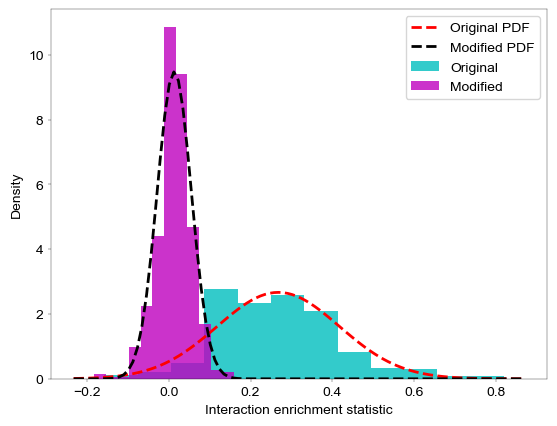

In [45]:
import matplotlib
from scipy.stats import norm, sem

EXP_NAME = 'IxnEnrichStatDist'
EFFECT = 'SmallChange'
PLOT_TYPE = 'Distributions'
FOV = 'FOV=10%'
filename = '_'.join([EXP_NAME, FOV, EFFECT, PLOT_TYPE]) + '.pdf'

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

plt.clf()
n = 500
mu_orig, std_orig = norm.fit(X1[:n])
mu_mod, std_mod = norm.fit(X2[:n])

plt.hist(X1[:n], color='c', label='Original', alpha = 0.8, density=True, bins=12 )
plt.hist(X2[:n], color='m', label='Modified', alpha = 0.8, density=True,  bins=12)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
orig_pdf = norm.pdf(x, mu_orig, std_orig)
mod_pdf = norm.pdf(x, mu_mod, std_mod)

plt.plot(x, orig_pdf, 'r--', linewidth=2, label='Original PDF')
plt.plot(x, mod_pdf, 'k--', linewidth=2, label='Modified PDF')

plt.ylabel('Density')
plt.xlabel('Interaction enrichment statistic' )
plt.legend()

#plt.savefig('./cohort_comparison/' + filename)
plt.show()

In [46]:
perm_test.perform_z_test(X1, X2)

(2.7512052406381566, 0.002968821449441217)

In [47]:
from scipy import stats

ns = np.arange(1, 600)
X1_bar = np.mean(X1)
X2_bar = np.mean(X2)

sigma_1 = np.std(X1)
sigma_2 = np.std(X2)

n_1 = len(X1)
n_2 = len(X2)

sem_1 = sigma_1/np.sqrt(ns)
sem_2 = sigma_2/np.sqrt(ns)

z = (np.abs(X1_bar-X2_bar)) / np.sqrt(sem_1 + sem_2)
p = 1 - stats.norm.cdf(z)



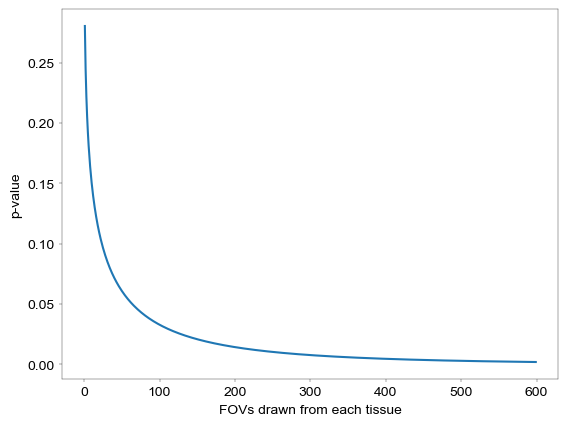

In [48]:
plt.clf()
PLOT_TYPE = 'PowerVSampleSize'
filename = '_'.join([EXP_NAME, EFFECT, FOV, PLOT_TYPE]) + '.pdf'

plt.plot(ns, p)
plt.xlabel('FOVs drawn from each tissue')
plt.ylabel('p-value')
#plt.hlines(0.05, xmin=1, xmax=max(ns), c='r--')
#plt.savefig('./cohort_comparison/' + filename)
plt.show()

In [49]:
effects = np.linspace(0, 1, 500)
X1_bar = np.mean(X1)
X2 = X1_bar + effects
X2_bar = np.mean(X2)

sigma_1 = np.std(X1)
sigma_2 = np.std(X2)

n_1 = len(X1)
n_2 = len(X2)

sem_1 = sigma_1/np.sqrt(len(X1))
sem_2 = sigma_2/np.sqrt(len(X1))

z = (np.abs(effects)) / np.sqrt(sem_1 + sem_2)
p = 1 - stats.norm.cdf(z)


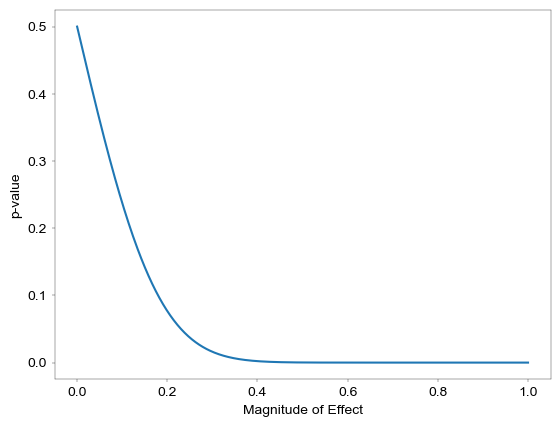

In [50]:
PLOT_TYPE = 'PowerVEffectSize'
filename = '_'.join([EXP_NAME, EFFECT, FOV, PLOT_TYPE]) + '.pdf'
plt.clf()
plt.plot(effects, p)
plt.xlabel('Magnitude of Effect')
plt.ylabel('p-value')
#plt.savefig('./cohort_comparison/' + filename)
plt.show()

In [ ]:
perm_test.perform_z_test(X1, X2)

(3.45944236648, 0.0002706475521578877)